# 2020.06.01_online_pca
-----
* Reimplemeting statfacs using online pca


### Version Info
* madmax: `9833fa6` `1c84f9e`
* research: `1ea52be`, `c070363`

---
## History


#### `2020.05.28_baselines.ipynb`
-----
* Baselines for the technical features data 
* testing gradeitn descent vs mbprox
* testing fast vs slow hl_2 in onlineRnn

#### `2020.05.27 statfacs grid`
* Statfacs initialized with the loadings from the previous minibatch
* Building an online model using statfacs as both features and residualization target
* Comprehensive grid of statfacs


##### `etf_technical_2020.05.27 (more statfacs)`
* Statfacs initialized with the loadings from the previous minibatch
* Building an online model using statfacs as both features and residualization target


##### `etf_technical_2020.05.19 (stat factors).ipynb`
* Computed statistical factors using
    + random initialization  in minibatches
    + iteratively added new statfacs - maintaining orthogonality to previous statfacs
    + different kappas and window lenghts
* Established baselines for the model withotu statfacs
* Ran some basic regressions with statfacs (not residualization)



##### `etf_technical_2020.05.17 (features profiling).ipynb`. 
* adding ta-lib like features for 500 ETFs. Feature profiled, online learning model

##### `etf_technical_2020.05.13`
* I had gotten omega weighting done (seems to add a little bit but not much)


In [4]:
import yahoo_historical
yahoo_historical

<module 'yahoo_historical' from '/home/fj/anaconda3/lib/python3.7/site-packages/yahoo_historical/__init__.py'>

In [7]:
# preamble
%alias_magic  nbagg matplotlib -p nbagg
%alias_magic  inline matplotlib -p inline
%load_ext memory_profiler
%load_ext line_profiler

from pylab import *
from madmax.api import *
mx = mx.reload()
mxtr = mxtr.reload()
plt.style.use('seaborn-whitegrid')

###################################################################
# Interactive configuration
# When running a config grid this will throw a FrozenException
# and the grid Config will be used
###################################################################
try:
    mx.Config.name = 'etf_technical/factor_timing/'
    mx.Config.mode = 'interactive'
    mx.Config.hps = mx.HPSet()
    mx.Config.code = 'factor_timing_2020.05.28.ipynb'
    disp('Running interactive configuration ', h=2)
except mx.Config.FrozenException:
    if mx.Config.mode != 'grid':
        raise RuntimeError('An unexpected configruation encountered')
    disp('Running a grid configuration ', h=2)

device = 'cuda'
dtype = tr.float32
mx.Config.start()
hps = mx.Config.hps

# to run run a grid of hyperparameters ...
####################################
# # hyperparameters
# mx.Config.hps = fr.HPSet(
# )
# mx.Config.code = ''
# # configs = []
# # for obs_weight in ['no_weight', 'dollar_weight', 'log_weight']:
# #     cfg = fr.Config.clone()
# #     cf
# #     cfg.hps = cfg.hps.clone( obs_weight=obs_weight )
# #     cfg.freeze()
# #     display_html( cfg )
# #     configs.append( cfg )
# # notebook = fr.Config.run_grid( configs, outfile=fr.Config.uri+'/../cadre_price_index.20200302 - weight_grid_results.ipynb', n_jobs=None )

Created `%nbagg` as an alias for `%matplotlib nbagg`.
Created `%inline` as an alias for `%matplotlib inline`.
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


## interactive global hyperparameters

In [8]:
# global  configruation
#######
if mx.Config.mode == 'grid':
    raise mx.Config.FrozenException( 'running grid configruation - skipping')

hps.start = '20070101'
hps.end='20200501'
hps.INTS_PER_DAY = 13

hps.universe = mx.HPSet(
    start = '20100101',
    end='20200401',
    min_count=2000,
    min_dollar_vol=1e5
)


hps.feature_set = mx.HPSet(
    unadj_prices=[
        'open_unadj_30min', 'high_unadj_30min', 'low_unadj_30min', 'close_unadj_30min', 'mid_unadj_30min',
        'log_open_unadj_30min', 'log_close_unadj_30min',
    ],
    adj_prices=[
        'open_adj_30min', 'high_adj_30min', 'low_adj_30min', 'close_adj_30min',
        'mid_adj_30min', 'mid_adj_0D.12h.vwap', 'mid_adj_2D.12h.vwap', 'mid_adj_5D.vwap',
        'open_adj_0D.12h', 'high_adj_0D.12h', 'low_adj_0D.12h',
        'open_adj_2D.12h', 'high_adj_2D.12h', 'low_adj_2D.12h',
        'open_adj_5D', 'high_adj_5D', 'low_adj_5D',
    ],
    rel_prices=[
        'rel_price_260', 'rel_price_780', 'rel_price_3276',
    ],
    volumes=[
        'volume_unadj_30min', 'dollar_volume_unadj_30min', 'avg_dollar_volume',
    ],
    log_volumes=[
        'log10_dollar_volume_30min', 'log10_dollar_volume_30min_resid',
    ],
    rel_volume=[
        'rel_dollar_volume_260', 'rel_dollar_volume_780',
        'rel_dollar_volume_3276',
    ],
    calendar=[
        'timeofday', 'cos1_timeofday', 'cos2_timeofday', 'cos4_timeofday',
        'dayofweek', 'cos1_dayofweek', 'cos2_dayofweek',
        'weekofmonth', 'cos1_weekofmonth', 'cos2_weekofmonth',
        'monthofquarter', 'cos1_monthofquarter', 'cos2_monthofquarter',
        'quarterofyear', 'cos1_quarterofyear', 'cos2_quarterofyear',
    ],
    lagging=[
        'lagrtn_adj_30min', 'lagrtn_adj_1hr', 'lagrtn_adj_1day',
        'lagrtn_adj_30min_resid',
    ],
    mkt=[
        'mkt_lagrtn_30min',
        'mkt_lagrtn_30min_260.rw_sd', 'mkt_lagrtn_30min_780.rw_sd', 'mkt_lagrtn_30min_3276.rw_sd',
    ],
    vol=[
        'lagrtn_adj_30min_260.rw_sd', 'lagrtn_adj_30min_780.rw_sd', 'lagrtn_adj_30min_3276.rw_sd',
        'lagrtn_adj_30min_resid_260.rw_sd', 'lagrtn_adj_30min_resid_780.rw_sd', 'lagrtn_adj_30min_resid_3276.rw_sd',
    ],
    zscores=[
        'lagrtn_adj_30min_260.rw_zscore', 'lagrtn_adj_30min_780.rw_zscore', 'lagrtn_adj_30min_3276.rw_zscore',
        'lagrtn_adj_30min_resid_260.rw_zscore', 'lagrtn_adj_30min_resid_780.rw_zscore',
        'lagrtn_adj_30min_resid_3276.rw_zscore',
    ],
    betas=[
        'lagrtn_adj_30min_1170.ew_beta', 'lagrtn_adj_30min_2340.ew_beta',
        'lagrtn_adj_30min_3276.ew_beta', 'lagrtn_adj_30min_6500.ew_beta',
    ],
    afacs=[ 'bw_afac_30min', 'fw_afac_30min' ],
    technical=[
        'true_range_30min', 'true_range_0D.12h', 'true_range_2D.12h', 'true_range_5D',
        'direction_30min', 'direction_0D.12h', 'direction_2D.12h', 'direction_5D',
        'delta_rtn_30min', 'delta_rtn_0D.12h', 'delta_rtn_2D.12h', 'delta_rtn_5D',
        'ttp_high_adj_0D.12h', 'ttp_high_adj_2D.12h', 'ttp_high_adj_5D',
        'ttp_low_adj_0D.12h', 'ttp_low_adj_2D.12h', 'ttp_low_adj_5D',    
    ],    
)

hps.leading_rtns = [
    'leadrtn_adj_30min', 'leadrtn_adj_1hr', 'leadrtn_adj_1day',
    'mkt_leadrtn_30min', 'mkt_leadrtn_1day',
]

hps.weights = ['valid_30min', 'weight', ]

    
hps.online = mx.HPSet(
    start=hps.start, #'20150101'
    end=hps.end, #  '20080101', # 
    batch_size=1000,
    features=sorted( set(
        []
        + ['open_unadj_30min', 'log_open_unadj_30min', 'lagrtn_adj_30min_resid', ]
        + hps.feature_set.lagging
        + hps.feature_set.vol
        + hps.feature_set.log_volumes
        # + hps.feature_set.calendar
        + hps.feature_set.mkt
        + hps.feature_set.betas
        # + hps.feature_set.technical
        # + hps.feature_set.afacs
    ) ),
    symbol=None,
    target='leadrtn_adj_30min',
    target_shift=None,  # advance the targetc
    lookahead=2,
    ridge=1e-5,
    hl_1=None,
    hl_2=None,
    lr=500,
    kappa=2,  # util penalty
    rnn_tv=None,  # {1:1, 2:1, 13:1e-1},
    ortho=2,
    ortho_hl=13,
    # orthogonalize out short term mean reversion
    ortho_features=['valid_30min', 'lagrtn_adj_30min', 'lagrtn_adj_1day'] + hps.feature_set.betas,
    weight='valid_30min',
    algo='mbprox',
    # stuff related to sid weighting
    use_omega='P',
    omega_lr=10,
    omega_ridge=0,
    omega_shift=0.1,
    # stuff related to pre and post processing
    winsorize_target=False,
    pre_winsorize=0.01,
    batch_demean=False,
    batch_normalize=False,
    transformer=mx.HPSet( pre_normalize=True, quadratic=True, post_normalize=True, ema_halflifes=[13 * 5, 13 * 20, 13 * 40], ),
    exposures=['valid_30min', 'lagrtn_adj_30min_1170.ew_beta', 'lagrtn_adj_30min']
)

<IPython.core.display.Javascript object>


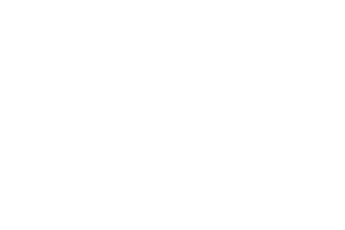

In [9]:
# identify the universe of ETFS
#############################################################
%nbagg
from research.etf_technical import etf_data_apr2020 as etfd; reload( etfd )

etf_stats = etfd.compute_etf_stats()
etf_stats = etf_stats[etf_stats.vendor=='kibot']
orig_len = len( etf_stats )
# drop etfs without enough history
etf_stats = etf_stats[(etf_stats['start'] <= hps.universe.start ) 
                      & (etf_stats['end'] > hps.universe.end ) 
                      & (etf_stats['n'] >= hps.universe.min_count)
                      & (etf_stats['daily_dollar_volume_adj'] >= hps.universe.min_dollar_vol ) ]

disp( 'after filtering', len( etf_stats ), 'symbols out of original ' ,orig_len )

etf_stats = (etf_stats
             .merge( etfd.all_etfs, how='left', left_on='symbol', right_on='Symbol' )
             .drop( columns=['Symbol', 'ETP Name', 'Leveraged / Inverse' ])
             .rename( columns={'Asset Class':'asset_class', 'Description':'name'} )
             .fillna( 'Not Specified')             
             .set_index('symbol')
            )
disp( etf_stats.groupby('asset_class').name.count() )

ax = subplot( 2,2, 1 )
etf_stats.n.hist(ax=ax, bins=50)
ax.set_title( 'counts')

ax = subplot( 2,2, 2 )
etf_stats.start.hist(ax=ax, bins=50)
ax.set_title( 'start dates')

ax = subplot( 2,2, 3 )
etf_stats.daily_dollar_volume_adj.log10().hist(ax=ax, bins=50)
ax.set_title( 'log10 daily dollar volume')

# this is the universe we will work with. 
# HERO has a massive returns spike in 2015.11.09 - which throws off residualization quite a bit.
hps.universe.symbols = sorted( etf_stats.index.values )


In [10]:
# build up the data and features
#############################################
%inline
from research.etf_technical import etf_data_apr2020 as etfd; reload( etfd )
from research.etf_technical import etf_technical_20200517 as etfrc; reload( etfrc )

# fetch the data as a dataarray
builder = etfd.BuildDataWithAfacs( symbols=hps.universe.symbols, mkt_only=True, start=hps.start ,).set( memoize=True )
builder.data = None
disp( 'builder BuildDataWithAfacs_7f79ef4bf  expected got', builder.hash() )
da = builder(  )
df = builder.output_meta

# hyperparams related to computing returns and residuals
hps.returns_hps = mx.HPSet(    
    price_windows=[ 24*1, 24*5, 24*10],
    beta_halflifes=[13 * 90, 13 * 180, 13 * 252, 13*500],
    dollar_volume_window=13*180,
    ema_halflifes=[20 * 13, 60 * 13, 252 * 13],
    resid_halflife=13,
    
)
# compute log-returns, log-dollar-volume, betas, residual returns and clean up the data
rtn_computer = etfrc.compute_returns_and_betas( 
    start=hps.start, end=None,     
    dollar_volume_window=hps.returns_hps.dollar_volume_window, 
    price_windows = hps.returns_hps.price_windows,
    beta_halflifes=hps.returns_hps.beta_halflifes, 
    resid_halflife=None,    
) 
rtn_computer.data = builder
disp( 'expected compute_returns_and_betas_9280a30dd got', rtn_computer.hash(), h=4, color='teal' )

# add relative price and relative volume features
rel_price_and_vols = etfrc.add_relative_price_and_volumes( emas=hps.returns_hps.ema_halflifes )
rel_price_and_vols.data = rtn_computer
disp( 'expected add_relative_price_and_volumes_a65da371a got', rel_price_and_vols.hash(), h=4, color='teal' )

# add volatility and calendar features
add_vols = etfrc.add_volatilities( emas=hps.returns_hps.ema_halflifes )
add_vols.data = rel_price_and_vols
disp( 'expected add_volatilities_77ca914f0 got', add_vols.hash(), h=4, color='teal' )

da = add_vols(  )

In [11]:
##### Profile the various sub-feature sets computed (don't run this too often )
##############################################################################
%inline
@mx.operatorize( memoize=True, produces_features=False )
def FeatureCorrelations( data, features, start, frac=0.5 ):
    '''computer feature set correlations'''
    data = data.loc[start:, :, features]
    if frac:
        ix = pd.Series( range( len( data ) ) ).sample( frac=frac, random_state=1 )
        data = data[ix.values]
    return data.corr_mx()

def process_one_feature_set( data, fs_features=None, leading=hps.leading_rtns ):
    '''profile one feature set '''
    with mx.timer( 'computing feautre coorelations' ):
        fc = FeatureCorrelations( start=None )
        fc.data = data
        fc.features = fs_features + leading
        corr_df = fc()
    with mx.timer( 'running profile' ):
        #  -- profile the features
        profiler = mx.FeatureProfiler(
            returns=['leadrtn_adj_30min', 'leadrtn_adj_1day',],
            exposures=['valid_30min', 'lagrtn_adj_30min_1170.ew_beta', 'mkt_lagrtn_30min'],
            transforms=None, weight='weight', winsorize=0.05, xs=None, start=None,
            lags=[1, 3, 5], autocorr=[1, 2, 13]
        ).set( verbose=False, memoize=True )
        profiler.data = data
        profiler.features = fs_features
        profiler.run()
    return corr_df, profiler

# for fs in ['statfac', 'technical', 'afacs', 'betas' ]: #+ list( hps.feature_set.keys() ):    
#     fs_features = getattr( hps.feature_set, fs )
#     disp( 'processing ', fs_features, h=2 )
#     corr_df, profiler = process_one_feature_set( fs_features=fs_features ) 
#     mx.disp( corr_df.loc[fs_features], corr=True )    
#     profiler.display()     

# Baselines
----

## online RNN learning  baseline 
### ( deleted the cell output like the fucking moron that I am)
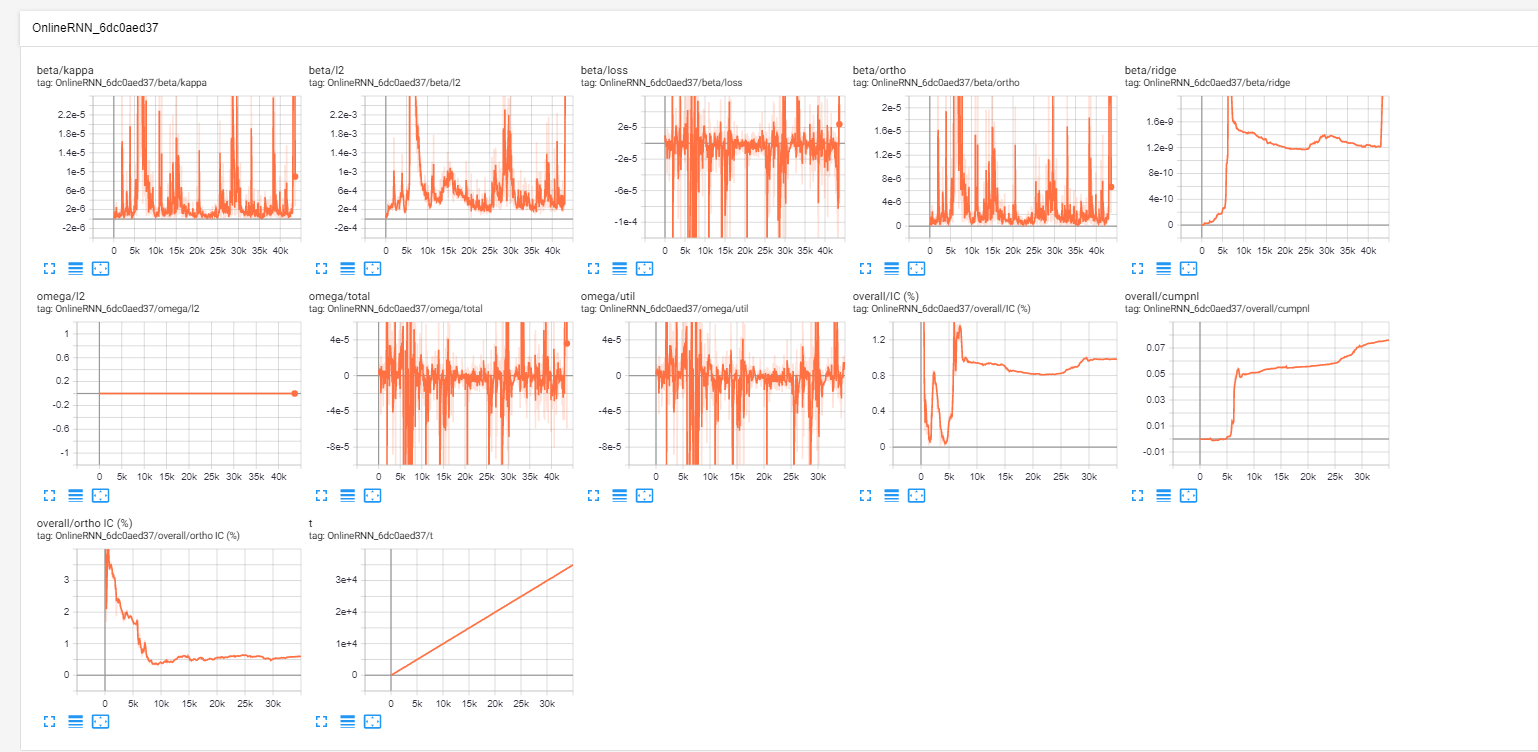

In [ ]:
# # online learning - baseline 1
# #################
%inline

from research.etf_technical import online_runner as reor; reload( reor )

data = add_vols

disp( mx.tensorboard.start_server() )
disp( mx.tensorboard.start( clear=True ) )

# --- run a basic configuration ---
if True:
    hpso = hps.online.clone()
    runner = reor.OnlineRunner( hps=hpso, verbose=True ).set( memoize=True )
    runner.data = data
    disp( f'Expected OnlineRunner_9426f9f7a  got ', runner.hash(), h=3, color='teal' )
    dfo = runner()
    disp( hpso )
    for profile in runner.output_meta:
        main_fig = profile['main_fig']
        exp_fig = profile['exp_fig']
        reg_fig = profile['reg_fig'] 
        reg_df = profile['regressions']
        if not reg_df.empty:
            reg_df = reg_df.set_index( ['returns', 'lag'] )
        disp( profile['feature'], profile['transform'], h=3, hr=True )
        # disp( pd.DataFrame( profile, index=['value'] ) )
        disp( 'Regressions', reg_df, h=4 )
        disp( reg_fig  )
        disp( exp_fig )


# baseline 2 - run again with better logging with post xswins and xszscore of forecast

research: # `4228`
madmax: # `0c08dd6`

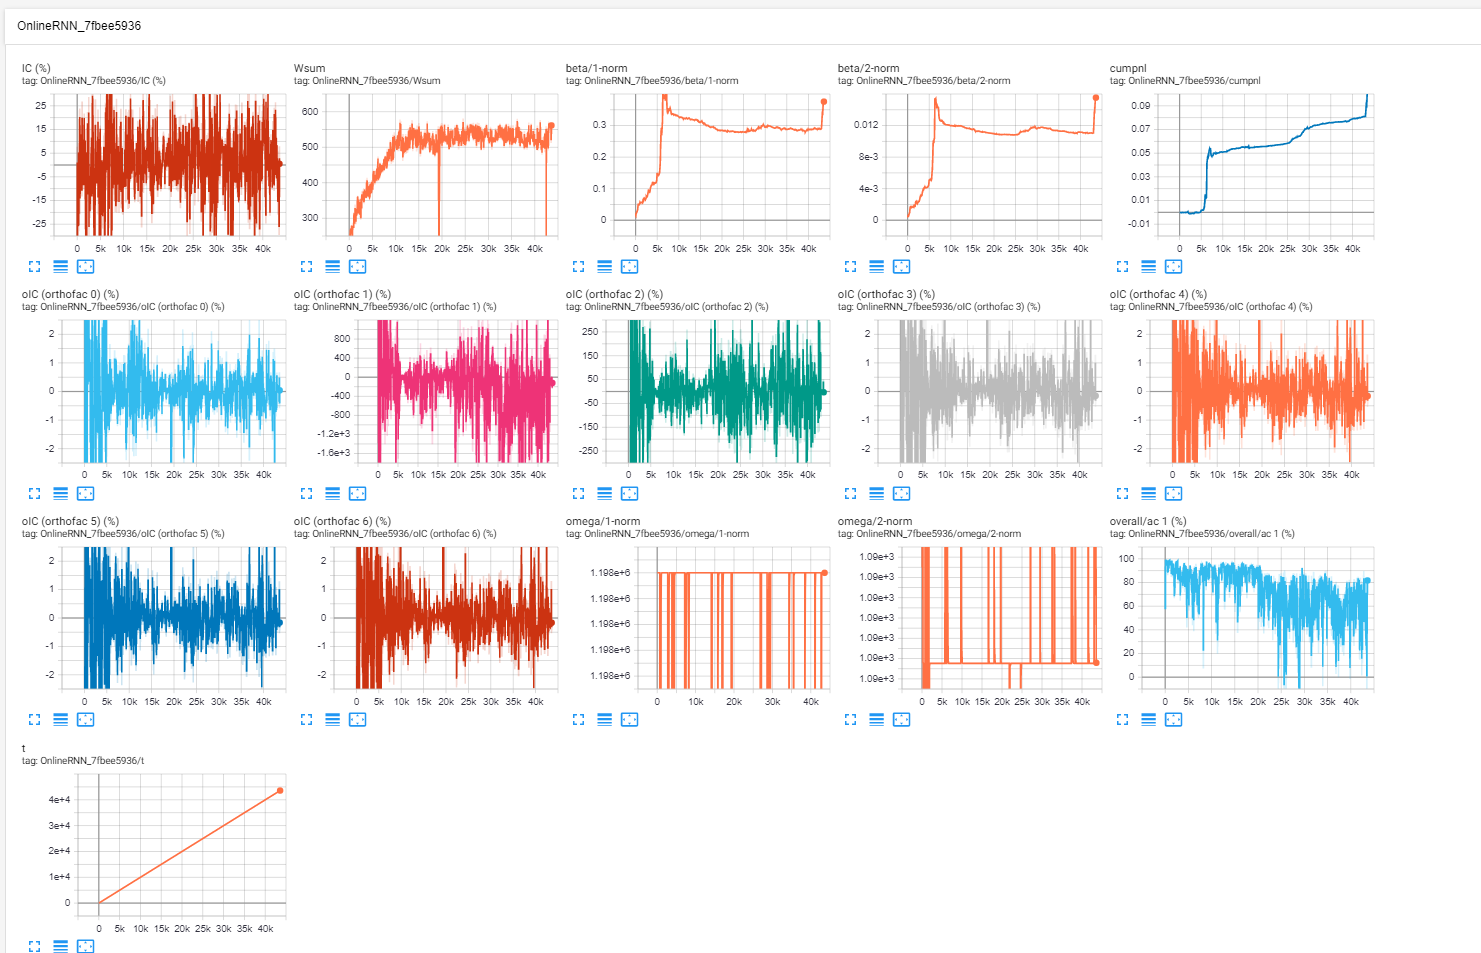


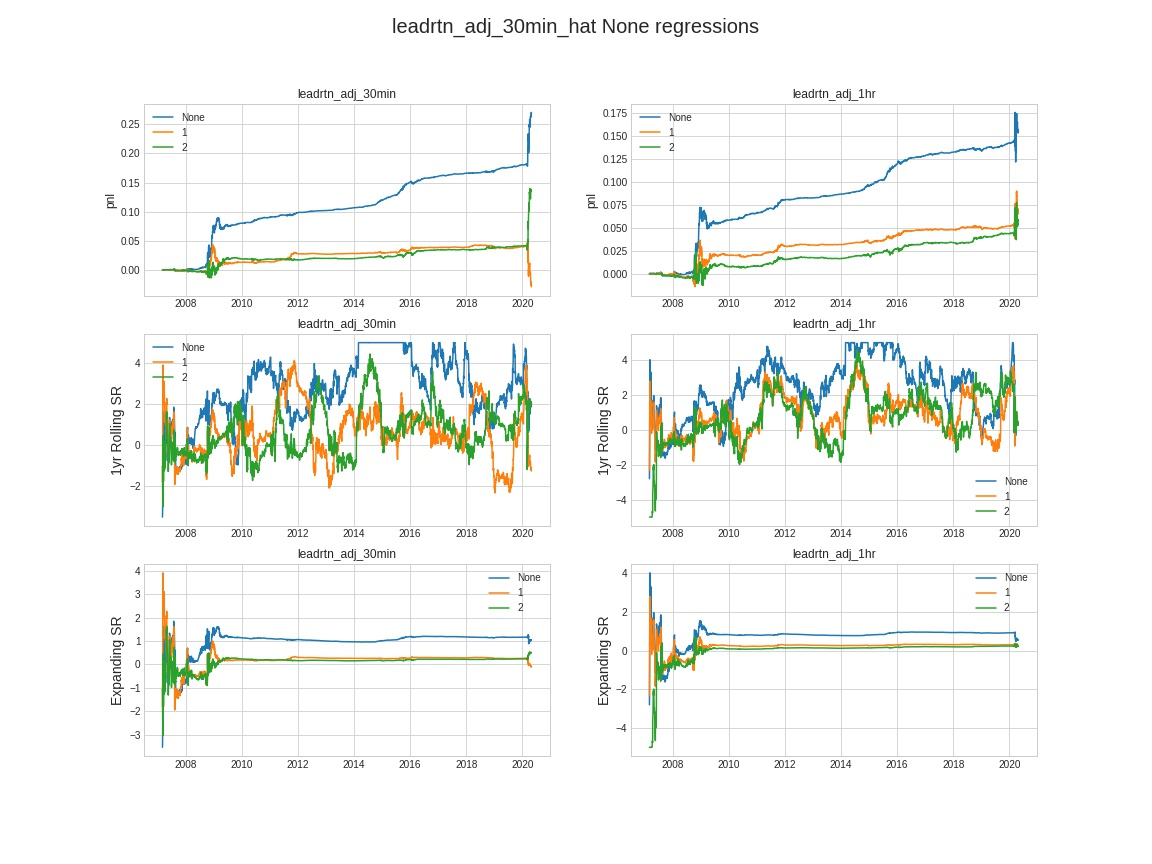

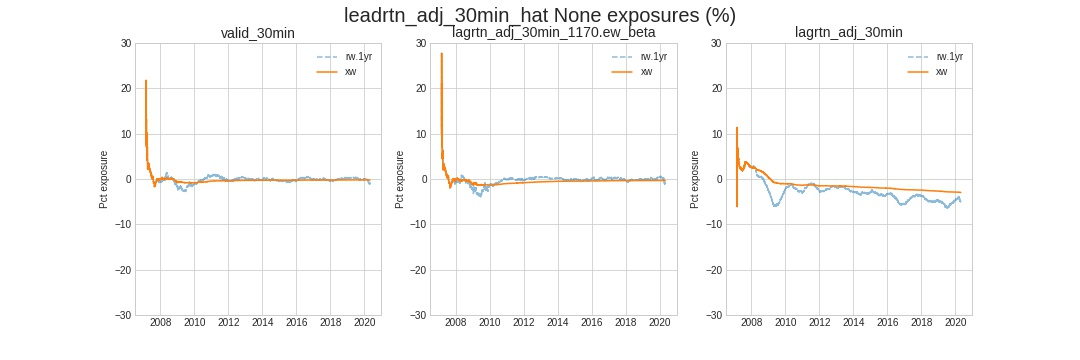

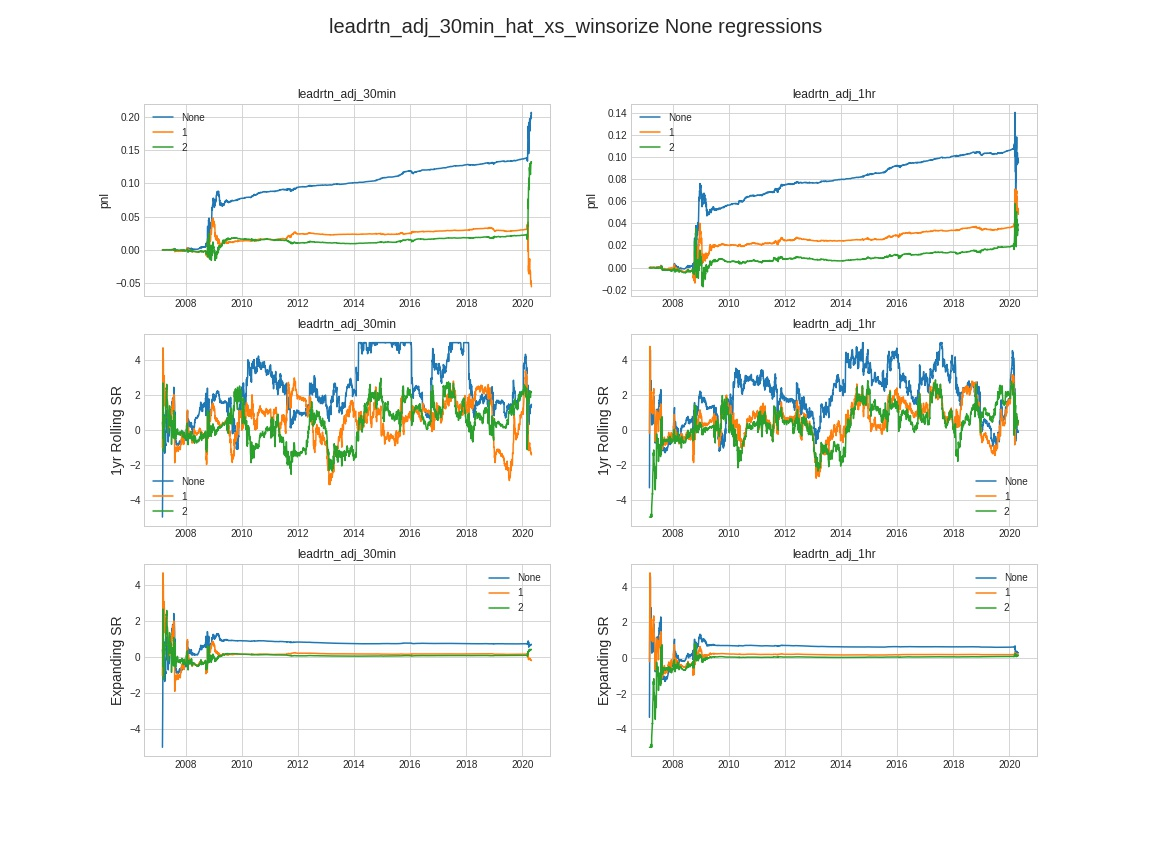

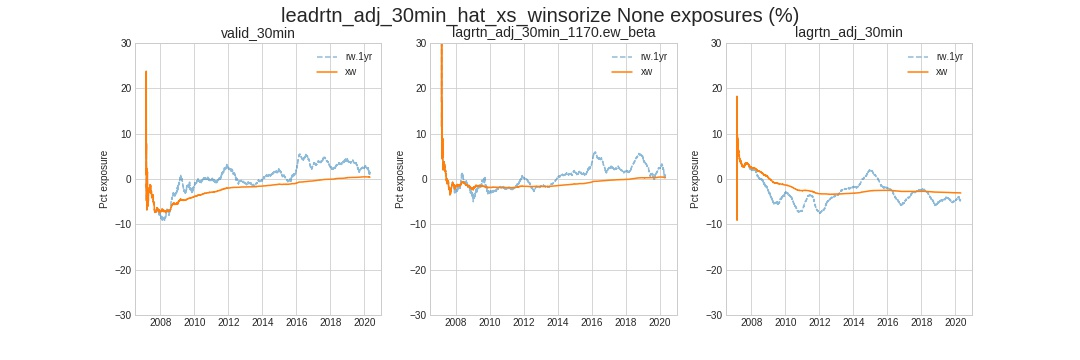

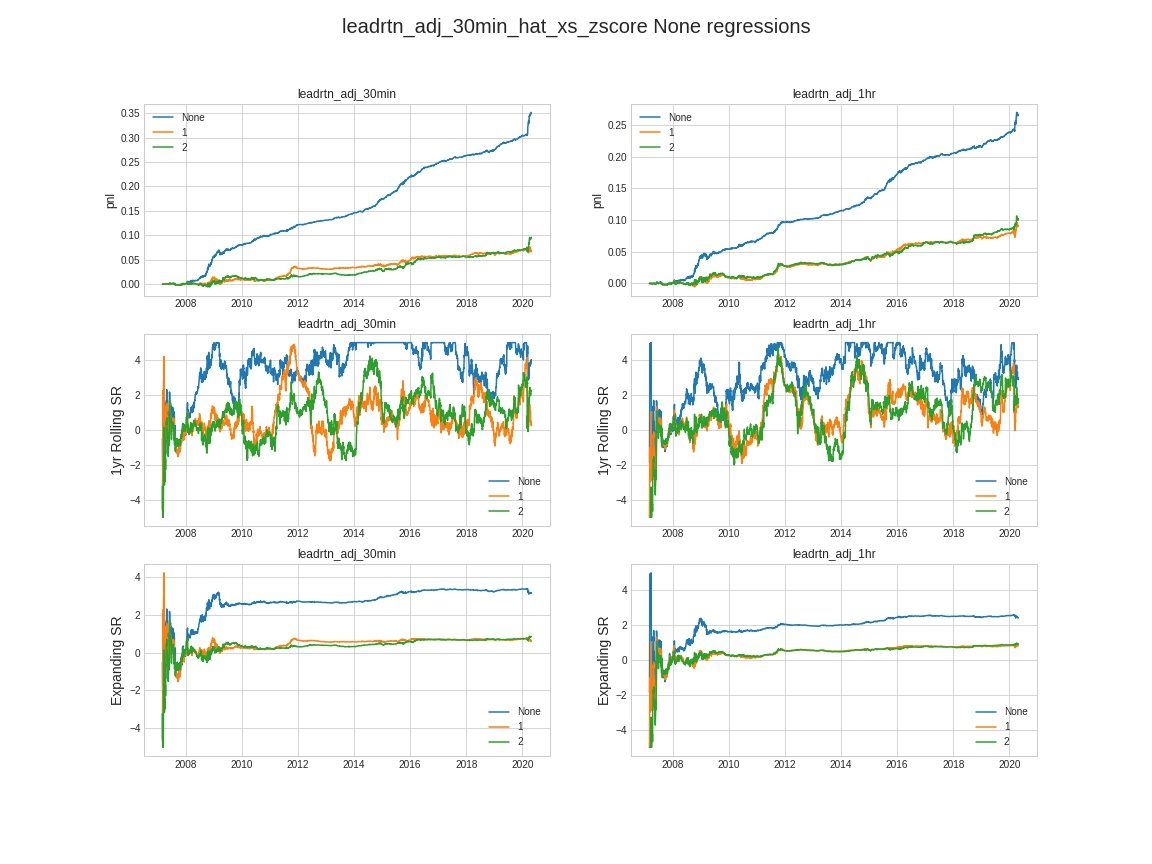

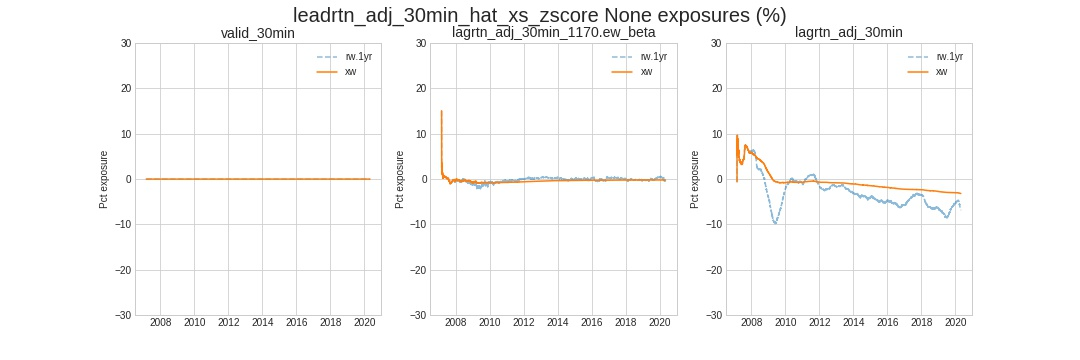

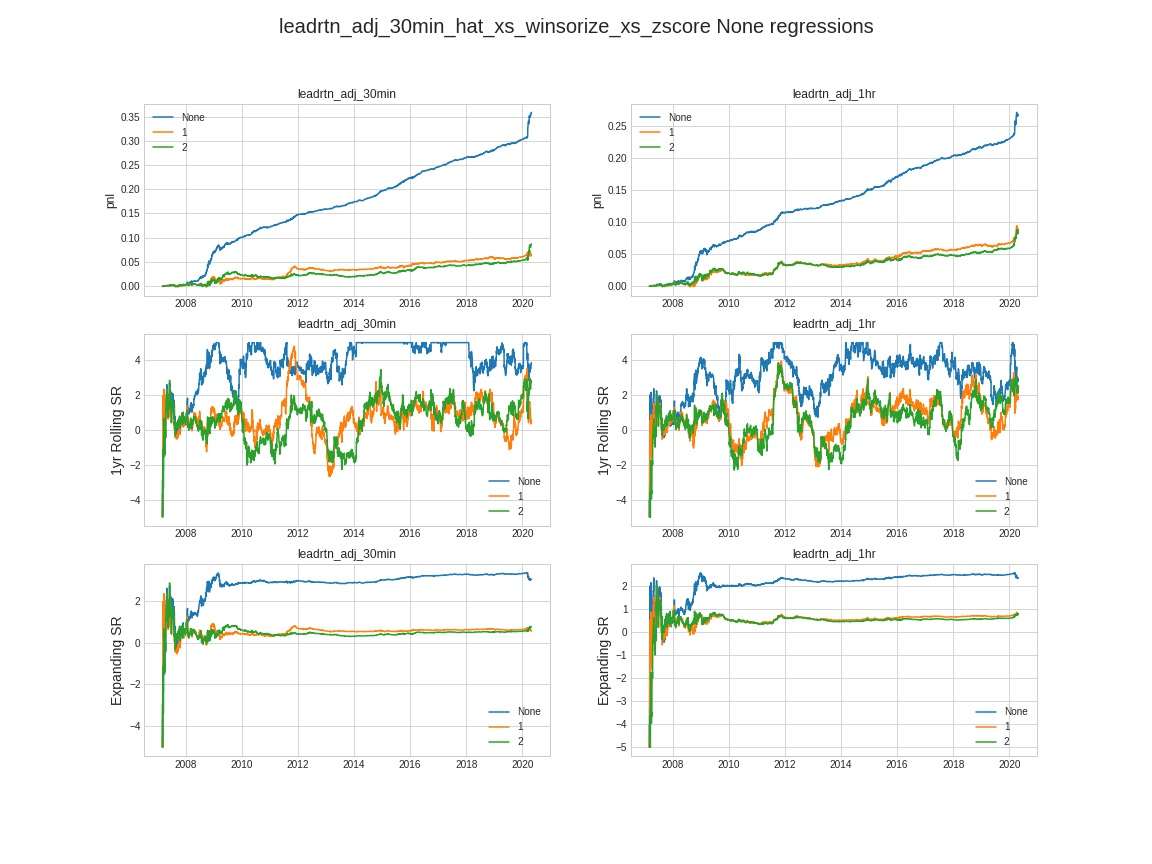

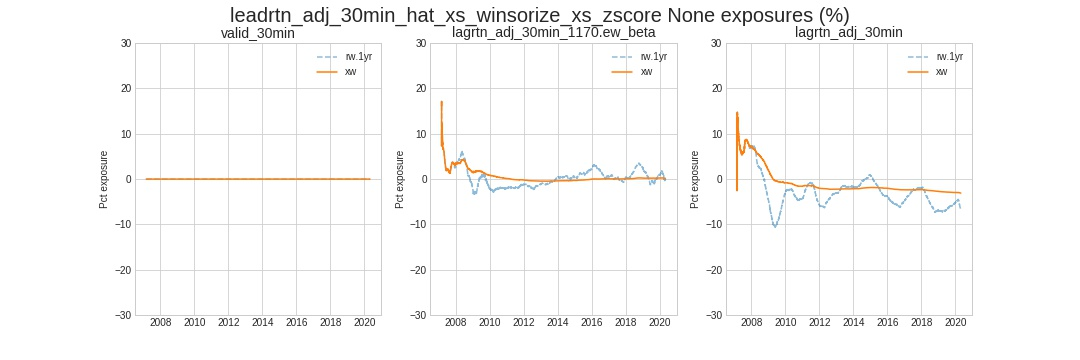

In [7]:
# online learning - baseline 2
#################
%inline

from research.etf_technical import online_runner as reor; reload( reor )

data = add_vols

disp( mx.tensorboard.start_server() )
disp( mx.tensorboard.start( clear=True ) )

hps.online = mx.HPSet(
    start=hps.start, #'20150101'
    end=hps.end, #  '20080101', # 
    batch_size=1000,
    features=sorted( set(
        []
        + ['open_unadj_30min', 'log_open_unadj_30min', 'lagrtn_adj_30min_resid', ]
        + hps.feature_set.lagging
        + hps.feature_set.vol
        + hps.feature_set.log_volumes
        # + hps.feature_set.calendar
        + hps.feature_set.mkt
        + hps.feature_set.betas
        # + hps.feature_set.technical
        # + hps.feature_set.afacs
    ) ),
    symbol=None,
    target='leadrtn_adj_30min',
    target_shift=None,  # advance the targetc
    lookahead=2,
    ridge=1e-5,
    hl_1=None,
    hl_2=None,
    lr=500,
    kappa=2,  # util penalty
    rnn_tv=None,  # {1:1, 2:1, 13:1e-1},
    ortho=2,
    ortho_hl=13,
    # orthogonalize out short term mean reversion
    ortho_features=['valid_30min', 'lagrtn_adj_30min', 'lagrtn_adj_1day'] + hps.feature_set.betas,
    weight='valid_30min',
    algo='mbprox',
    # stuff related to sid weighting
    use_omega='P',
    omega_lr=10,
    omega_ridge=0,
    omega_shift=0.1,
    # stuff related to pre and post processing
    winsorize_target=False,
    pre_winsorize=0.01,
    batch_demean=False,
    batch_normalize=False,
    transformer=mx.HPSet( pre_normalize=True, quadratic=True, post_normalize=True, ema_halflifes=[13 * 5, 13 * 20, 13 * 40], ),
    exposures=['valid_30min', 'lagrtn_adj_30min_1170.ew_beta', 'lagrtn_adj_30min']
)

# --- run a basic configuration ---
if True:
    hpso = hps.online
    runner = reor.OnlineRunner( hps=hpso, verbose=True ).set( memoize=True )
    runner.data = data
    disp( f'Expected OnlineRunner_d88739236  got ', runner.hash(), h=3, color='teal' )
    dfo = runner()
    disp( hpso )
    for profile in runner.output_meta:
        main_fig = profile['main_fig']
        exp_fig = profile['exp_fig']
        reg_fig = profile['reg_fig'] 
        reg_df = profile['regressions']
        if not reg_df.empty:
            reg_df = reg_df.set_index( ['returns', 'lag'] )
        disp( profile['feature'], profile['transform'], h=3, hr=True )
        # disp( pd.DataFrame( profile, index=['value'] ) )
        disp( 'Regressions', reg_df, h=4 )
        disp( reg_fig  )
        disp( exp_fig )

## The online pca runner


In [12]:
# the online pca runner
###################################
from madmax.algos.online import pca as mxpca; reload(mxpca)
from research.etf_technical import online_runner as reor; reload( reor )

@mx.operatorize( produces_features=True, produces_meta=True )
def OnlinePCARunner( data, features, hps ):
    if hps.start:
        data = data.loc[hps.start:]
    if hps.end:
        data = data.loc[:hps.end]
    for _ in range( 5 ):
        gc.collect();
        tr.cuda.empty_cache()
    mx.seed( 17 )
    
    # the online pca operator
    pca = mxpca.OnlinePCA.operator( weight=hps.weight, ortho_features=hps.ortho_features, batch_size=10000,
                                    halflife=hps.halflife, rank=hps.rank, kappa=hps.kappa, ortho=hps.ortho, tv=hps.tv,
                                    ortho_halflife=hps.ortho_halflife, ridge=hps.ridge, verbose=True, metadata=True, )
    data = pca( data=data, features=features )
    data = data.rename_coords( features={ x: f'{x}_kappa.{hps.kappa}_hl.{hps.halflife}' for x in pca.output_features } )
    output_factors = mx.Features( '/pca_factor.*/' ).find( data )
    output_eigens = mx.Features( '/pca_eigval.*/' ).find( data )
    
    # build output meta for returning
    results = pca.output_meta
    output_meta = dict( profiles=results['profiles'] )
    
    K = hps.rank
    P = len( features )
    R = len( hps.ortho_features )
    
    pnl = results['pnls']
    fig, axs = subplots( P, K, figsize=(K * 4, P * 4) )
    axs = np.atleast_2d( axs )
    for k, fac in enumerate( pnl.factors.values ):
        for p, tgt in enumerate( pnl.targets.values ):
            ax = axs[p][k]
            ax.plot( pnl[:, k, p].cumsum().to_series() / pnl[:, k, p].sum().item() )
            ax.set_xlabel( fac, fontsize=11 )
            ax.set_ylabel( tgt, fontsize=11 )
            ax.set_title( f'{fac} x {tgt}' )
    fig.suptitle( 'pnl', fontsize=16 )
    output_meta['pnl'] = mx.fig2format( fig )
    
    ic = results['ics']
    fig, axs = subplots( P, K, figsize=(K * 4, P * 4), sharex=True, sharey=True )
    axs = np.atleast_2d( axs )
    for k, fac in enumerate( ic.factors.values ):
        for p, tgt in enumerate( ic.targets.values ):
            ax = axs[p][k]
            ax.plot( ic[:, k, p].abs().to_series() * 100, '--k', alpha=0.1 )
            ax.plot( ic[:, k, p].to_series().rolling( 100 ).mean() * 100, '-k', alpha=0.8 )
            ax.set_xlabel( fac, fontsize=11 )
            ax.set_ylabel( tgt, fontsize=11 )
            ax.set_title( f'{fac} x {tgt}' )
    fig.suptitle( 'ics', fontsize=16 )
    output_meta['ics'] = mx.fig2format( fig )
    
    oic = results['oics']
    if oic is not None:
        fig, axs = subplots( R, K, figsize=(K * 4, R * 4) )
        axs = np.atleast_2d( axs )
        for k, fac in enumerate( oic.factors.values ):
            for r, ortho in enumerate( oic.orthos.values ):
                ax = axs[r][k]
                ax.plot( oic[:, k, r].to_series() * 100, '--k', alpha=0.1 )
                ax.plot( oic[:, k, r].to_series().rolling( 100 ).mean() * 100, '-k', alpha=0.8 )
                ax.set_xlabel( fac, fontsize=11 )
                ax.set_ylabel( ortho, fontsize=11 )
                ax.set_title( f'{fac} x {ortho}' )
        fig.suptitle( 'orthog-ics', fontsize=16 )
        output_meta['oics'] = mx.fig2format( fig )
    
    ac1 = results['ac1s']
    E = data.loc[:, 'SPY', output_eigens]
    fig, axs = subplots( 3, K, figsize=(K * 4, 15) )
    for k, fac in enumerate( pnl.factors.values ):
        ax = axs[0][k]
        ax.plot( ac1[:, k].to_series() * 100, '--k', alpha=0.1 )
        ax.plot( ac1[:, k].to_series().rolling( 100 ).mean() * 100, '-k', alpha=0.8 )
        ax.set_ylabel( 'ac1', fontsize=11 )
        ax.set_title( f'{fac} ac1' )
        ax = axs[1][k]
        ax.set_ylabel( 'AC1', fontsize=11 )
        ax.plot( E[:, k].to_series() * 100, '--k', alpha=0.1 )
        ax.plot( E[:, k].to_series().rolling( 100 ).mean() * 100, '-k', alpha=0.8 )
        ax.set_title( f'{fac} eig' )
        ax.set_ylabel( 'eig', fontsize=11 )
# ax = axs[2][k]
# ax.plot( X_norm[:, k].to_series(), '--k', alpha=0.1 )
# ax.plot( X_norm[:, k].to_series().rolling( 100 ).mean() * 100, '-k', alpha=0.8 )
# ax.set_title( f'{fac} norm' )
# ax.set_ylabel( 'norm', fontsize=11 )
    fig.suptitle( 'ac1, eigvals and norm', fontsize=16 )
    output_meta['facts'] = mx.fig2format( fig )
    
    return data, output_factors + output_eigens, output_meta


## online pca  - experiment 1

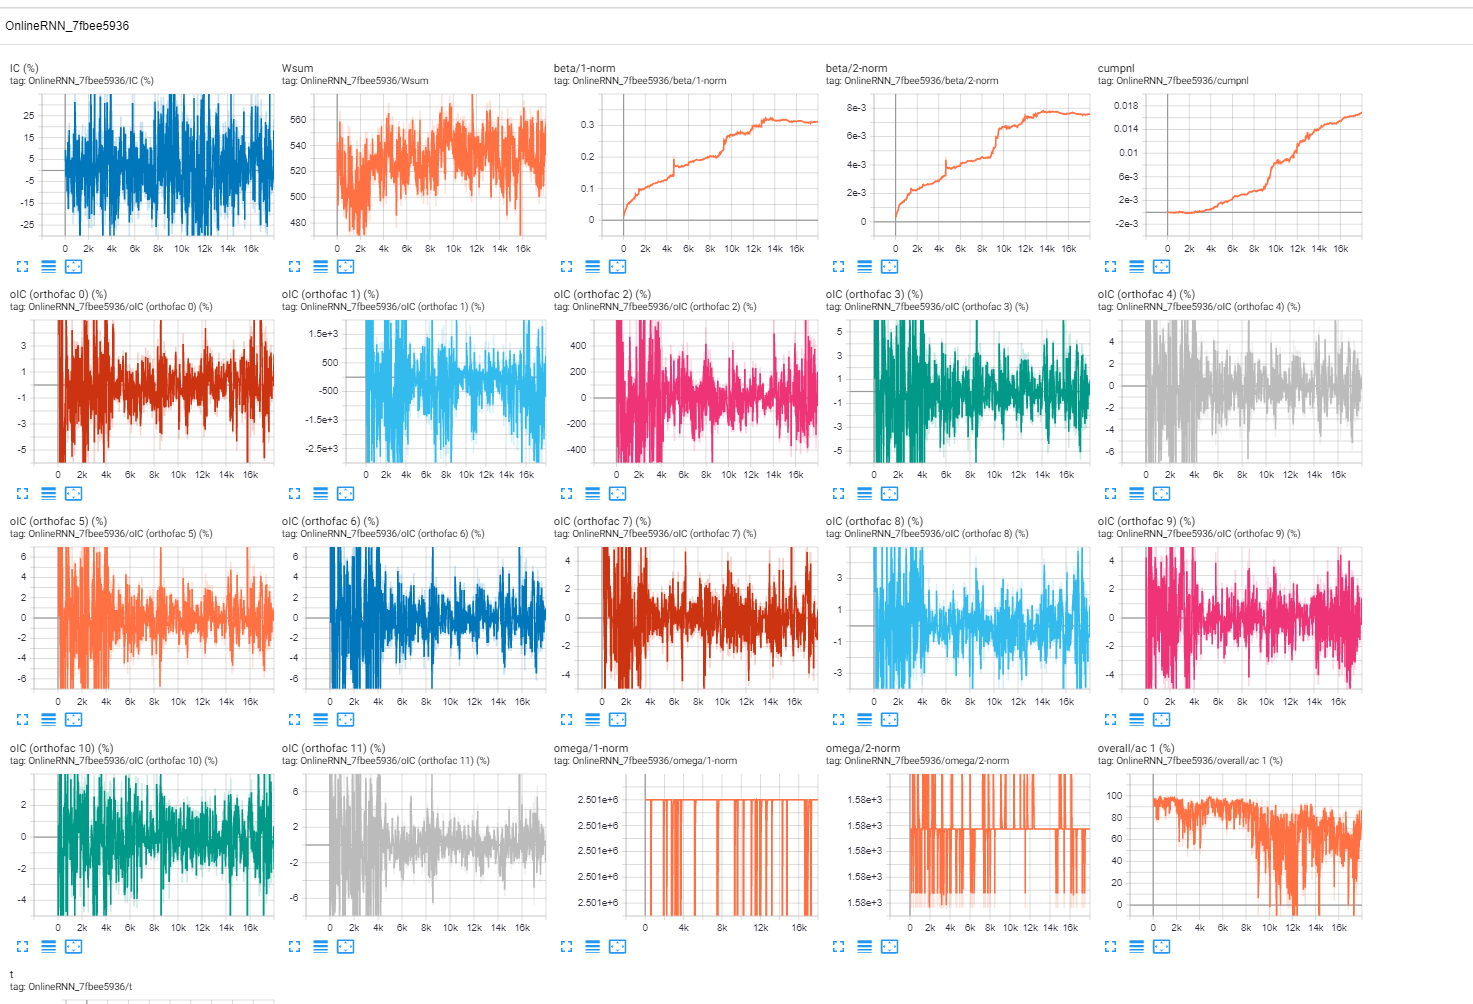

/home/fj/cloud/code/madmax/pytorch/modules/normalizations.py:122: UserWarning: norm of X is dangerously low 1.0143691042685532e-07
  warnings.warn( f'norm of X is dangerously low {X_norm.min()}' )


/home/fj/cloud/code/madmax/pytorch/modules/normalizations.py:122: UserWarning: norm of X is dangerously low 4.408286002899331e-08
  warnings.warn( f'norm of X is dangerously low {X_norm.min()}' )


/home/fj/cloud/code/madmax/pytorch/modules/normalizations.py:122: UserWarning: norm of X is dangerously low 4.6625908112218895e-07
  warnings.warn( f'norm of X is dangerously low {X_norm.min()}' )


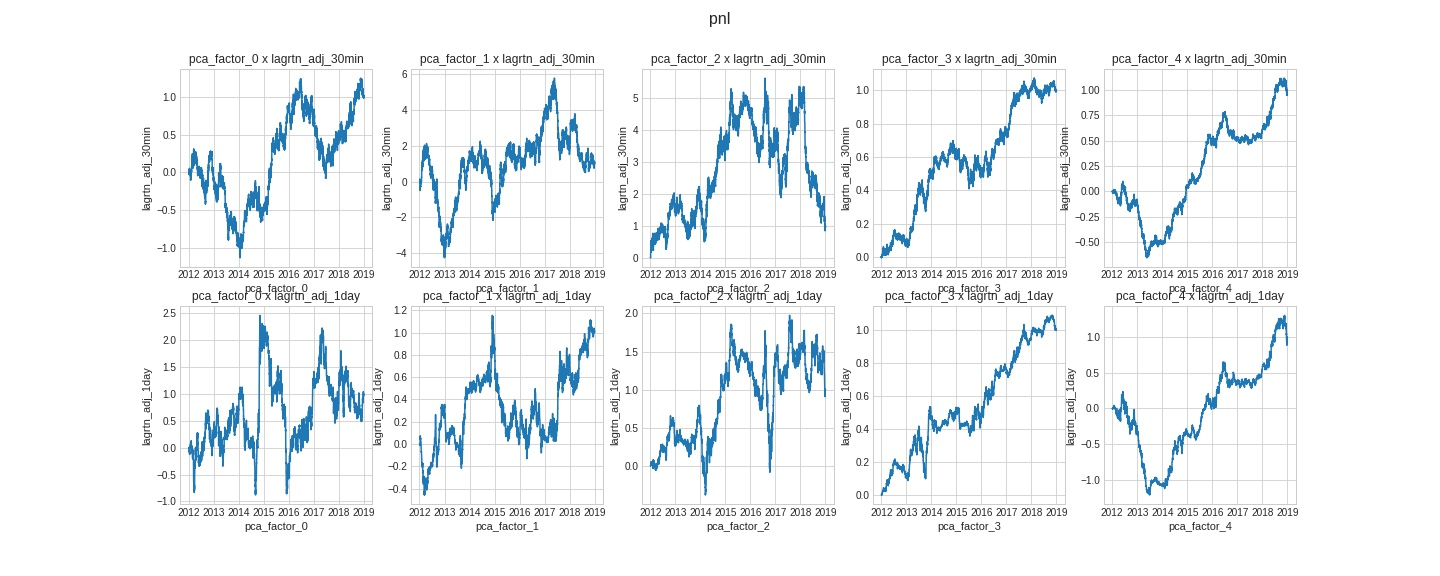

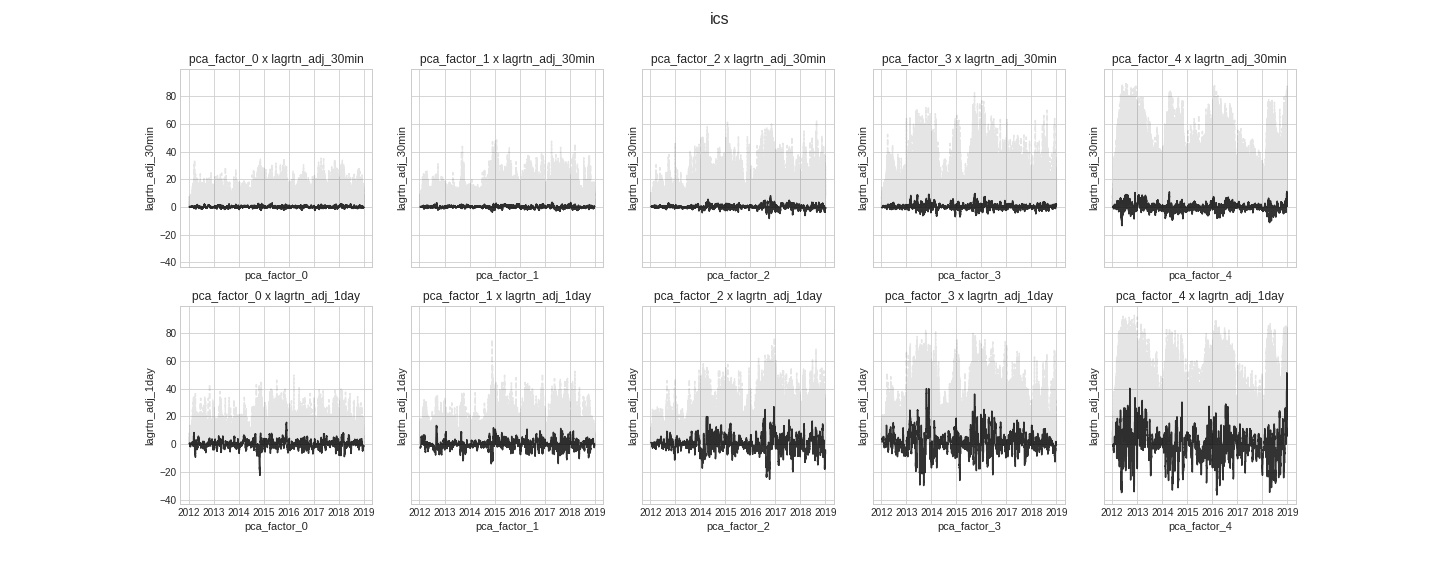

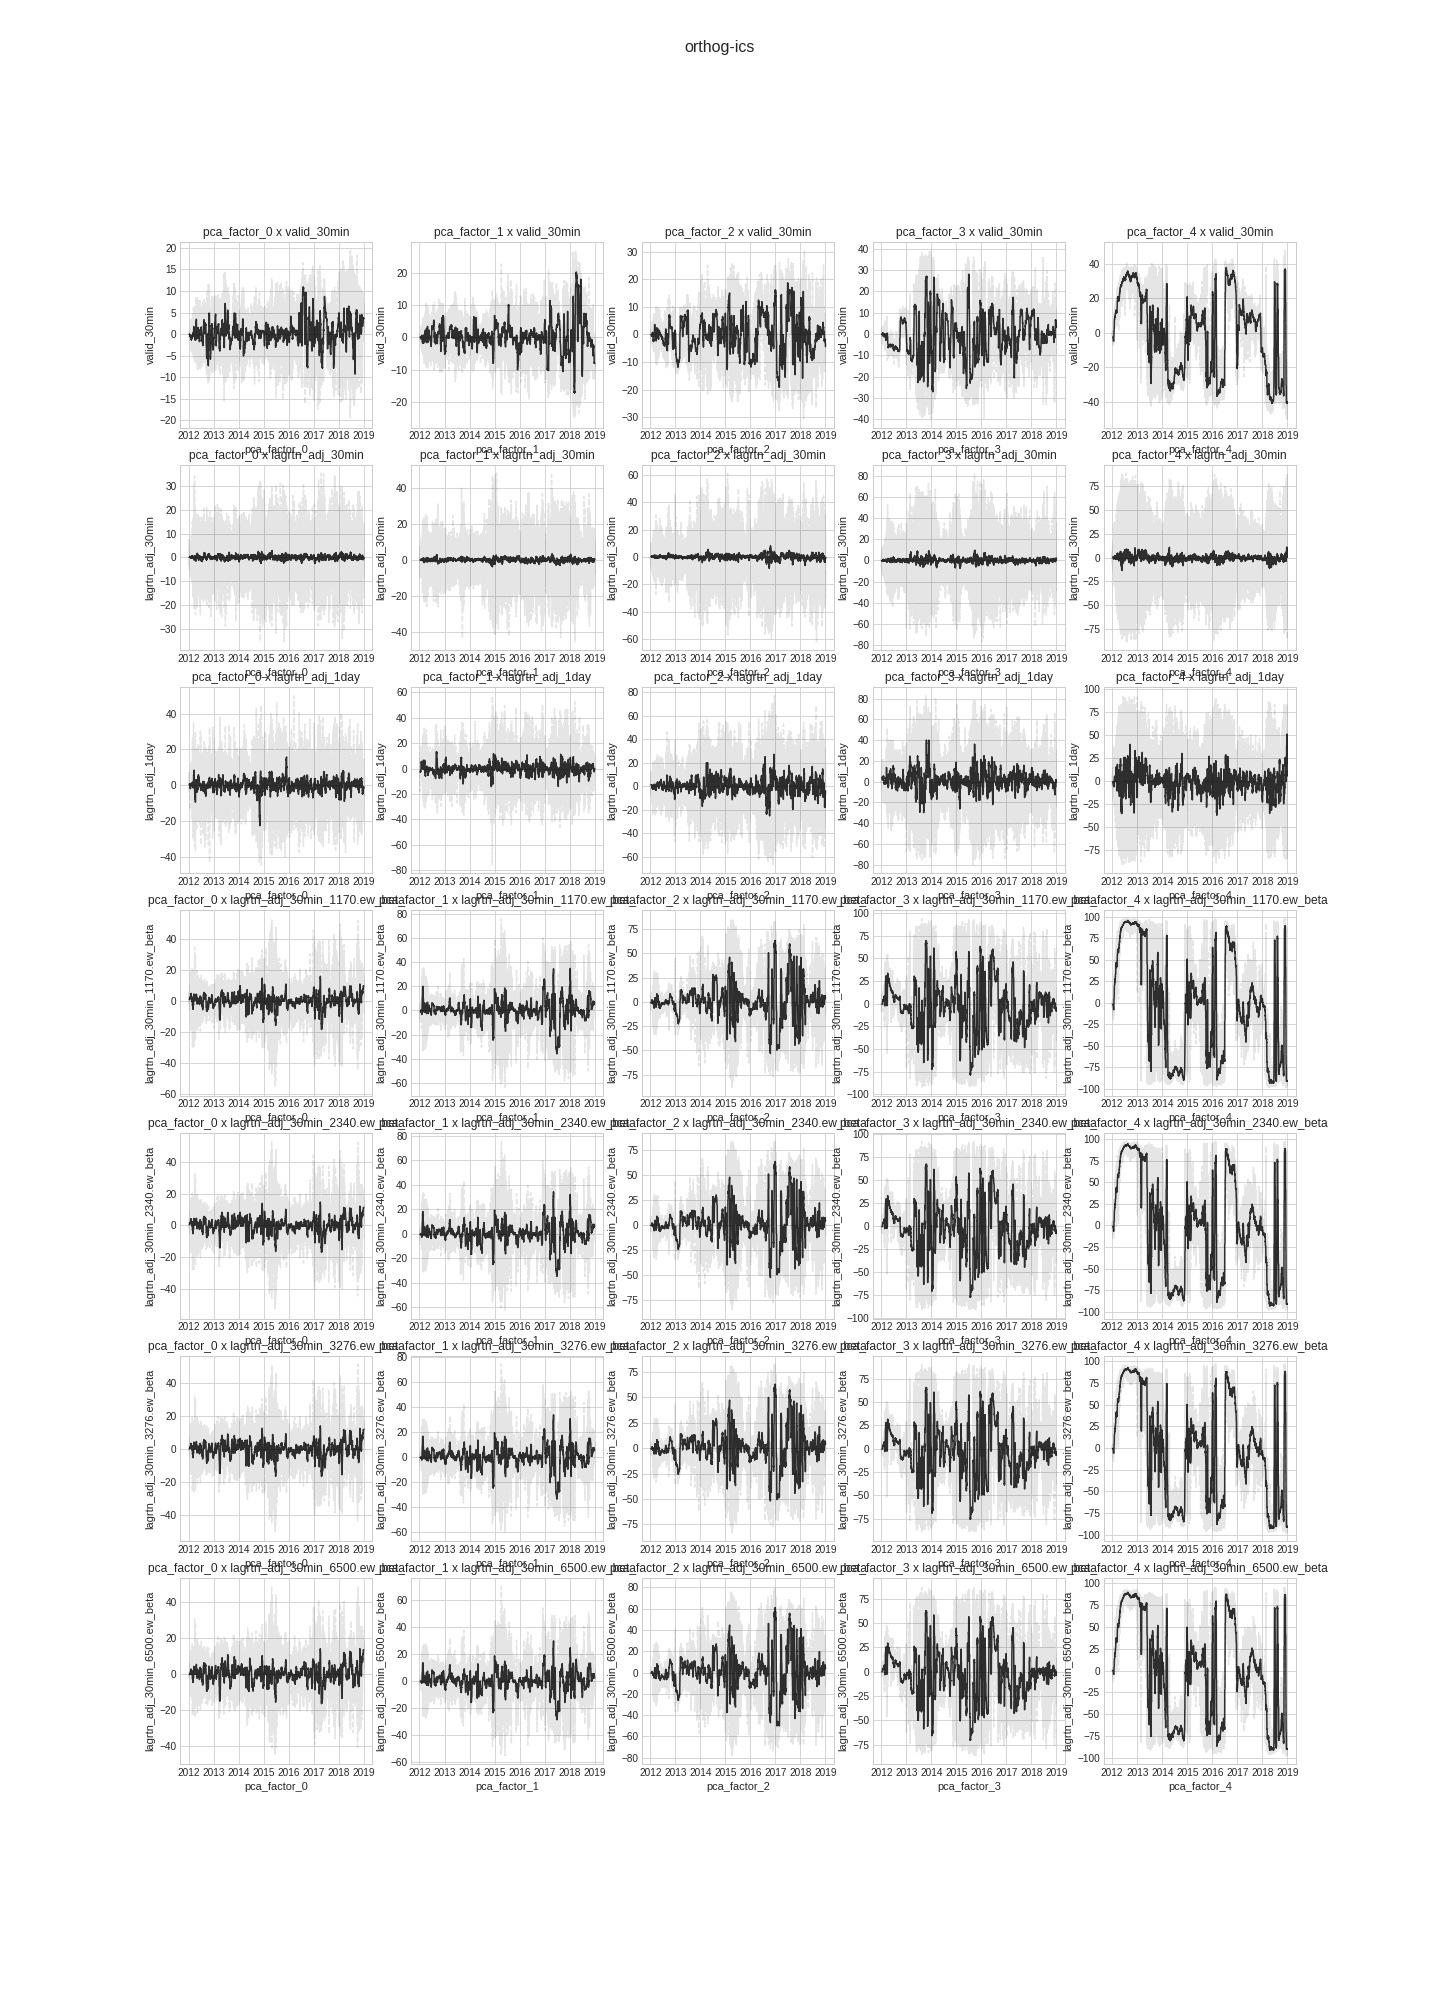

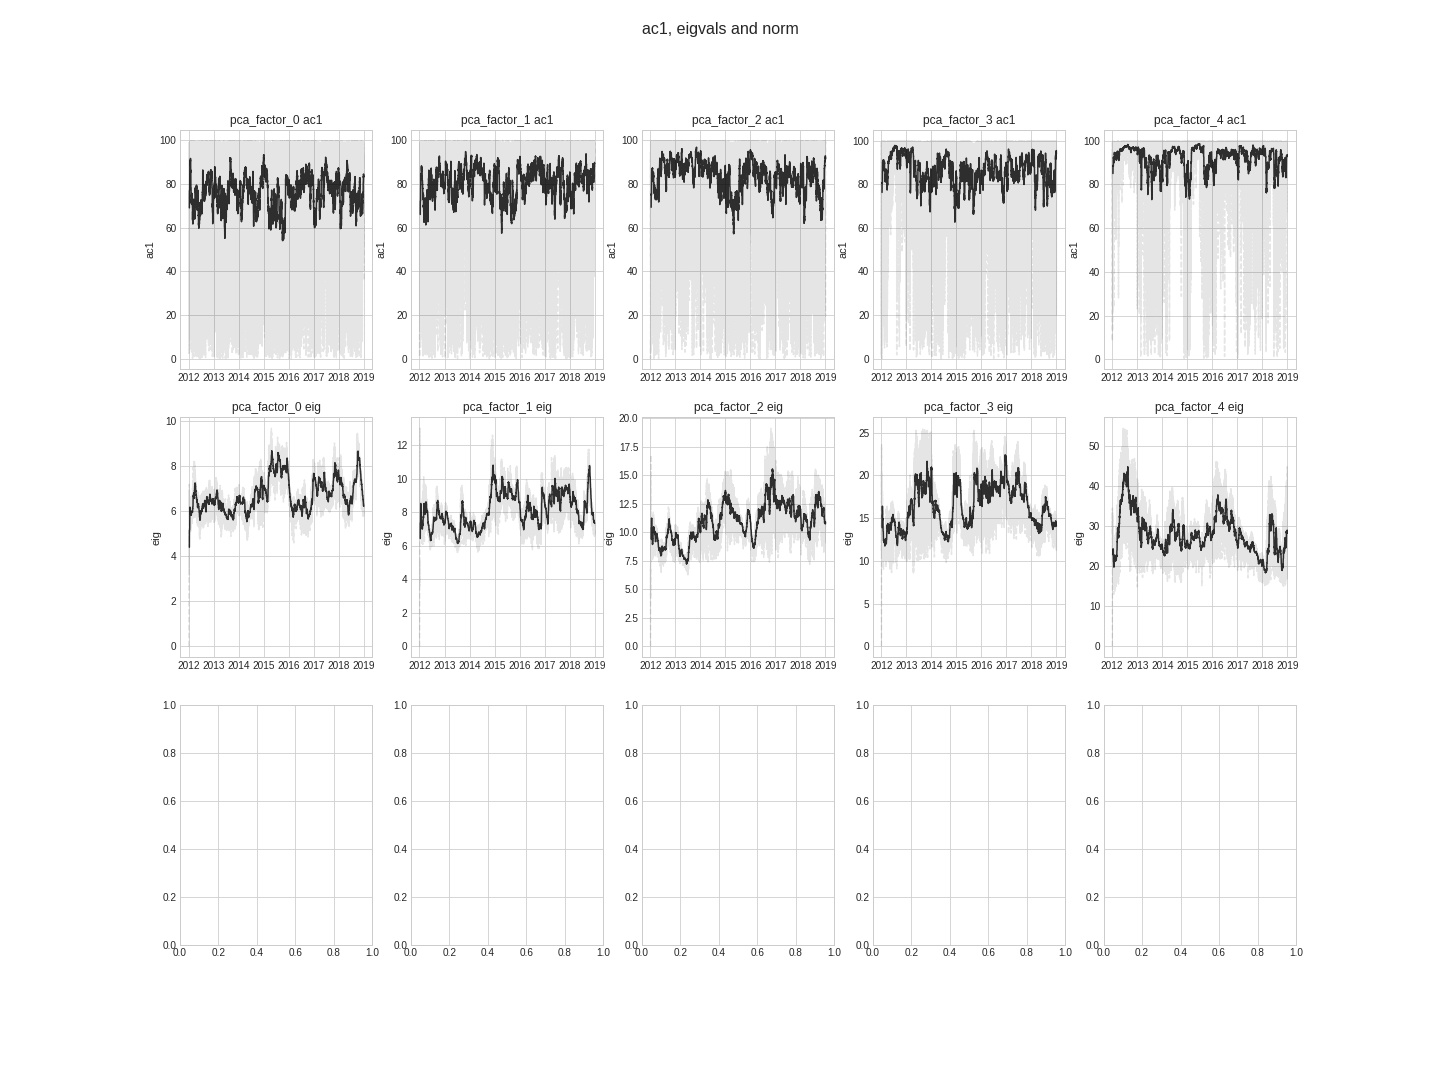

Exception in thread Thread-71:
Traceback (most recent call last):
  File "/home/fj/anaconda3/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/home/fj/anaconda3/lib/python3.7/site-packages/tensorboard/summary/writer/event_file_writer.py", line 211, in run
    self._record_writer.write(data)
  File "/home/fj/anaconda3/lib/python3.7/site-packages/tensorboard/summary/writer/record_writer.py", line 39, in write
    self._writer.write(header + header_crc + data + footer_crc)
  File "/home/fj/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/io/gfile.py", line 507, in write
    self.fs.append(self.filename, file_content, self.binary_mode)
  File "/home/fj/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/io/gfile.py", line 150, in append
    self._write(filename, file_content, "ab" if binary_mode else "a")
  File "/home/fj/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/io/gfile.py", line 

In [ ]:
# online pca -1
#############################

%inline

disp( mx.tensorboard.start_server() )
disp( mx.tensorboard.start( clear=True ) )

gc.collect();
tr.cuda.empty_cache()

hps.online_pca = mx.HPSet(
    targets=['lagrtn_adj_30min', 'lagrtn_adj_1day'],
    weight=['weight'],
    start='20120101',
    end='20190101',
    ortho_features=hps.online.ortho_features,
    halflife=30 * 13,
    rank=5,
    kappa=1e-1,
    ortho=1e-1,
    tv=None,
    ortho_halflife=None,
    ridge=1e-6,
)

pca_runner = OnlinePCARunner( hps=hps.online_pca ).set( memoize=False )
pca_runner.data = add_vols
pca_runner.features = hps.online_pca.targets
da_out = pca_runner()
output_factors = mx.Features( '/pca_factor_.*/' ).find( pca_runner.output_features )
output_eigvals = mx.Features( '/pca_eigval_.*/' ).find( pca_runner.output_features )
for k, v in pca_runner.output_meta.items():
    disp( k, h=2 )
    disp( v )

hpso = hps.online.clone(
    start=pd.to_datetime( hps.online_pca.start ) + pd.to_timedelta( 30, 'D' ),
    end=pd.to_datetime( hps.online_pca.end ),
    features=(hps.online.features + output_factors + output_eigvals),
    ortho_features=(hps.online.ortho_features + output_factors),
    batch_size=2000,
)
rnn_runner = reor.OnlineRunner( hps=hpso, verbose=True ).set( memoize=False )
rnn_runner.data = da_out
disp( f'Expected ...  got ', rnn_runner.hash(), h=3, color='teal' )
dfo = rnn_runner()
disp( hpso )
for profile in rnn_runner.output_meta:
    main_fig = profile.pop( 'main_fig' )
    exp_fig = profile.pop( 'exp_fig' )
    reg_fig = profile.pop( 'reg_fig' )
    reg_df = profile.pop( 'regressions' )
    if not reg_df.empty:
        reg_df = reg_df.set_index( ['returns', 'lag'] )
    disp( profile.pop( 'feature' ), profile.pop( 'transform' ), h=3, hr=True )
    # disp( pd.DataFrame( profile, index=['value'] ) )
    disp( 'Regressions', reg_df, h=4 )
    # disp( main_fig )
    disp( exp_fig )


In [10]:
%pdb

Automatic pdb calling has been turned ON
